# Оптимизация пользовательского опыта: тестирование форматов фотографий и кнопок в приложении для доставки

<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Для начала подгрузим все необходимые библиотеки
</div>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

import scipy.stats as st
import statsmodels.formula.api as smf 
import pingouin as pg
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

In [5]:
# Базовый URL для Яндекс.Диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Список файлов с их публичными ссылками и именами
files = [
    {'public_key': 'https://disk.yandex.ru/d/Ar_onoIjnPMWQg', 'filename': 'AB_task_1.csv'},
    {'public_key': 'https://disk.yandex.ru/d/76i1m3jp3kk6nw', 'filename': 'AB_task_2.csv'}
]

# Цикл для загрузки каждого файла
for file in files:
    public_key = file['public_key']
    filename = file['filename']
    
    # Формируем URL для получения прямой ссылки на скачивание
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    with open(filename, 'wb') as f:
        f.write(download_response.content)
    
# Загрузка файлов
exp1 = pd.read_csv('AB_task_1.csv')
exp2 = pd.read_csv('AB_task_2.csv')

###  1 шаг. Проверим, какой формат фотографий является наилучшим

In [6]:
exp1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.
</div>

In [8]:
pg.homoscedasticity(data=exp1, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


> **p-value > 0.05, не отклоняем нулевую гипотезу**

<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Проверим нормальность распределения.
</div>

In [12]:
exp1.groupby('group').agg({'id':'count'})

,id
group,
A,10000
B,10000
C,10000


> **У нас достаточно большое количество наблюдений, поэтому необходимо сделать сэмплирование либо использовать `"normaltest"`**

In [13]:
pg.normality(data=exp1, dv="events", group="group", method = "normaltest")

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


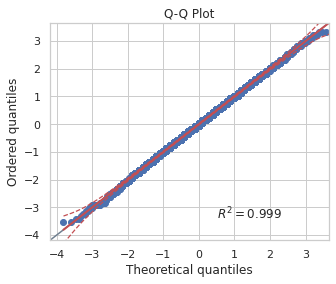

In [14]:
# qq-plots

pg.qqplot(exp1.query("group == 'A'").events)

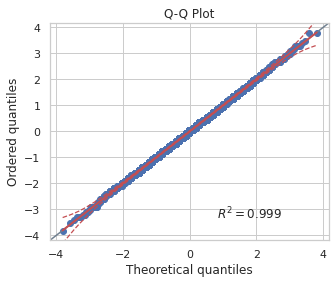

In [15]:
pg.qqplot(exp1.query("group == 'B'").events)

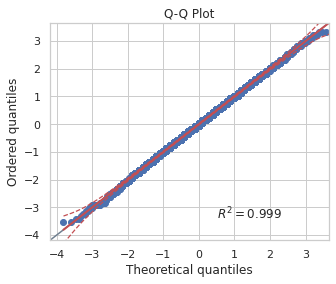

In [16]:
pg.qqplot(exp1.query("group == 'A'").events)

> **Вывод:** данные распределены нормально

<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Проведем тест с помощью однофакторного дисперсионного анализа
</div>

In [26]:
# scipy
st.f_oneway(exp1.query("group == 'A'").events, 
            exp1.query("group == 'B'").events, 
            exp1.query("group == 'C'").events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [18]:
# pingouin
pg.anova(data=exp1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


> **Статистика в тесте равна 2886, p-value 0.0 - различия есть**

<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Используем критерий Тьюки и определим, между какими группами есть статистически значимые различия. 
</div>

In [19]:
# statsmodels
MultiComp = MultiComparison(exp1['events'], groups=exp1['group'])

print(MultiComp.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


Text(0, 0.5, 'Число покупок')

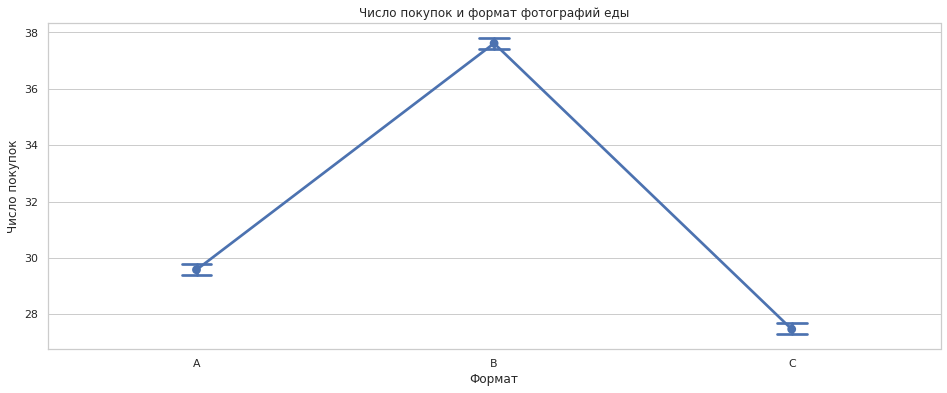

In [20]:
sns.pointplot(x = 'group', y = 'events', data = exp1, capsize = .1)
plt.title('Число покупок и формат фотографий еды')
plt.xlabel('Формат')
plt.ylabel('Число покупок')

In [21]:
# pingouin

pg.pairwise_tukey(data=exp1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


In [22]:
pg.pairwise_gameshowell(data=exp1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,0.001,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,0.001,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.001,1.024138


>**Вывод: выбираем картинки В, так как их среднее наибольшее (37.6136) и оно статистически значимо отличается от А и С**

### 2 шаг. Второй эксперимент 

In [7]:
exp2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Посмотрим на данные
</div> 

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


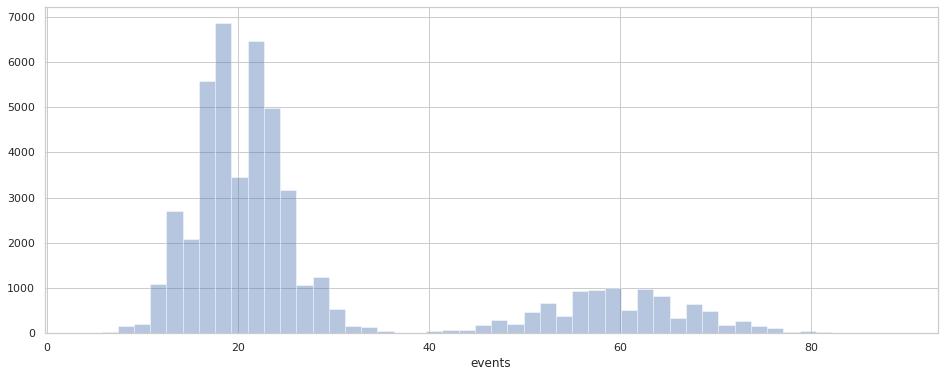

In [27]:
# Визуализируем распределение events для контрольной и тестовой групп
sns.distplot(exp2.query("group=='control'").events, kde = False)

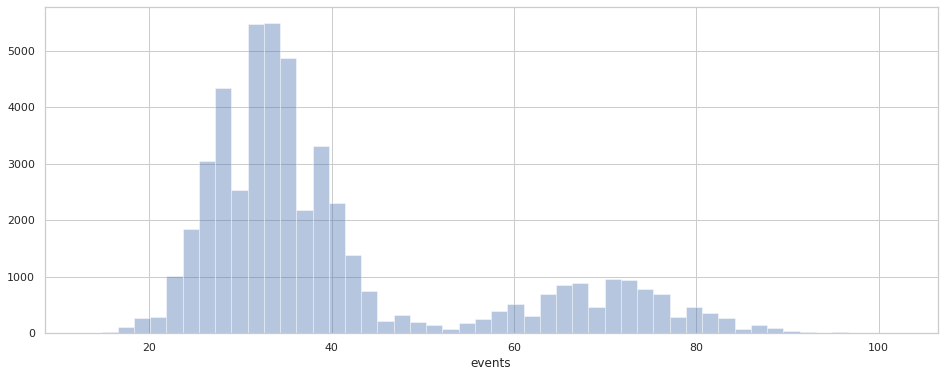

In [28]:
sns.distplot(exp2.query("group=='test'").events, kde = False)

In [29]:
# Посчитаем среднее, медиану и стандартное отклонение в разбивке по группе и по сегменту пользователя
exp2.groupby(['segment', 'group']).agg({'events':["mean", "median", "std"]}).round(2)

events             
                  mean median   std
segment group                      
high    control  59.97   60.0  7.81
        test     69.94   70.0  8.40
low     control  20.03   20.0  4.47
        test     33.03   33.0  5.72

In [30]:
exp2.groupby(['group', 'segment'])['events'].describe().T.round(2)

group     control                test          
segment      high       low      high       low
count    10000.00  40000.00  10000.00  40000.00
mean        59.97     20.03     69.94     33.03
std          7.81      4.47      8.40      5.72
min         31.00      4.00     40.00     13.00
25%         55.00     17.00     64.00     29.00
50%         60.00     20.00     70.00     33.00
75%         65.00     23.00     76.00     37.00
max         89.00     41.00    102.00     59.00

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


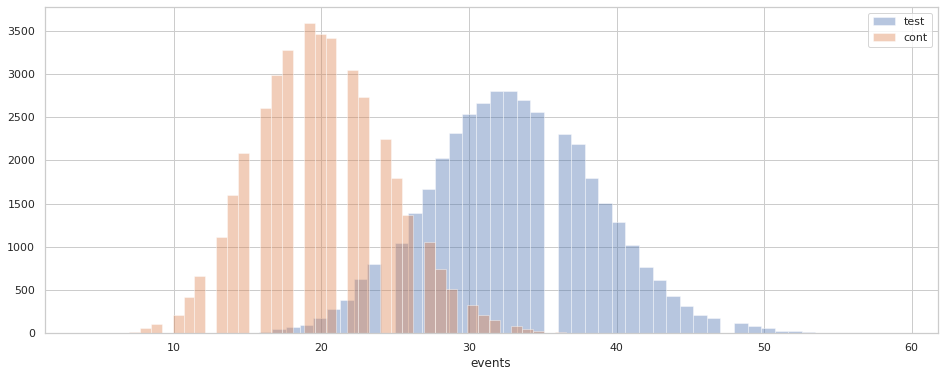

In [32]:
# Посмотрим на распределение сегмента 'low' в группах
sns.distplot(exp2.query("segment == 'low' & group=='test'").events, label='test', kde=False)
sns.distplot(exp2.query("segment == 'low' & group=='control'").events, label='cont', kde=False)
plt.legend()

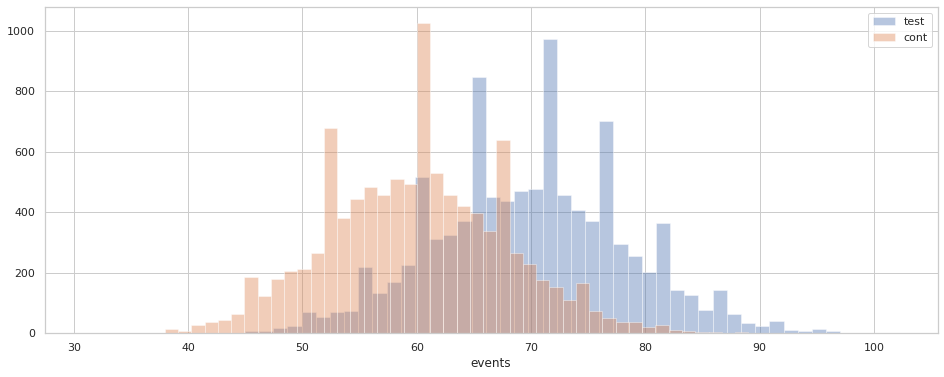

In [33]:
# Посмотрим на распределение сегмента 'high' в группах
sns.distplot(exp2.query("segment == 'high' & group=='test'").events, label='test', kde=False)
sns.distplot(exp2.query("segment == 'high' & group=='control'").events, label='cont', kde=False)
plt.legend()

<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Проверим эффект нескольких переменных – group и segment на events, с взаимодействием факторов.
    Применим многофакторный дисперсионный анализ.
</div> 

In [34]:
# statsmodels
model = smf.ols(formula='events ~ segment + group + segment:group', data=exp2).fit()
aov_table = anova_lm(model)

In [35]:
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [36]:
# pingouin

pg.anova(data=exp2, dv="events", between=["group", "segment"])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


>**Фактор group оказался *значимым*, фактор segment – *значимым*, их взаимодействие – *значимо*.**

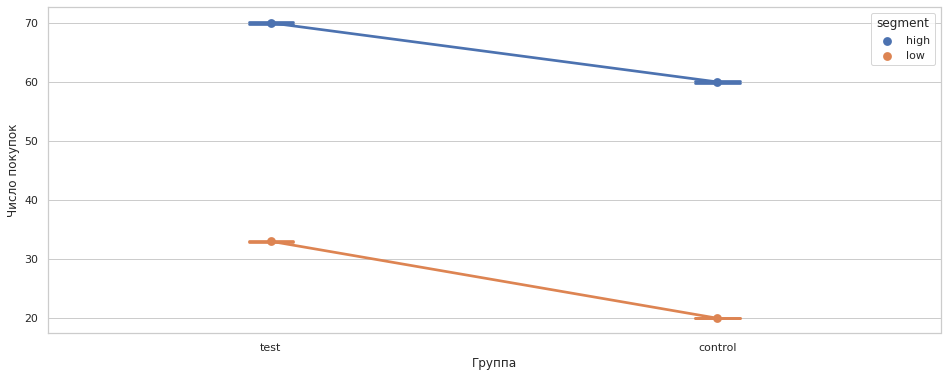

In [37]:
sns.pointplot(x = 'group', y = 'events', hue='segment', data = exp2, capsize = .1)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

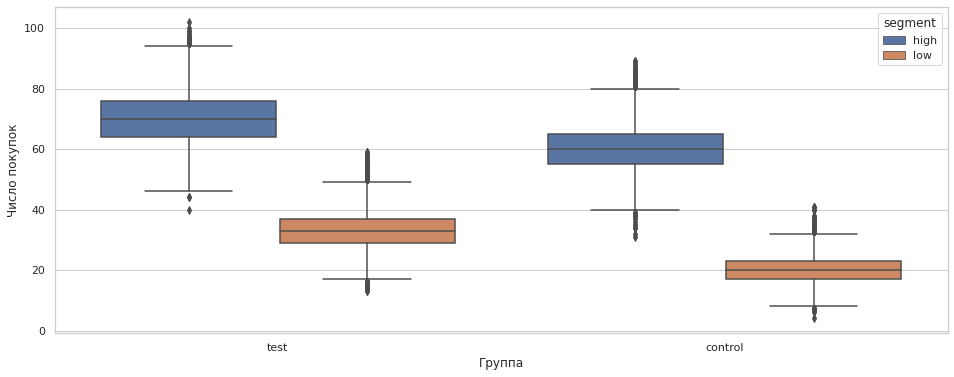

In [38]:
sns.boxplot(x = 'group', y = 'events', hue='segment', data = exp2)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

>**Судя по графику, для всех групп среднее значение `events` увеличилось, поэтому решение: выкатываем новую версию**